In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages
import mysql.connector

In [2]:
import sys

In [3]:
sys.executable

'/Library/Frameworks/Python.framework/Versions/3.8/bin/python3'

In [4]:
config = {
  'user': 'jbooks',
  'password': 'jbooks',
  'host': '127.0.0.1',
  'database': 'Library',
  'raise_on_warnings': True
}

cnx = mysql.connector.connect(**config)
all_books = pd.read_sql("Select * from books", cnx)
books_query = ("""
    SELECT
        b.book_id,b.title, b.genre, b.pages, b.duration, b.format, b.year, cr.started, cr.finished, cr.rating, pur.source, pub.imprint, DATEDIFF(cr.finished, cr.started) 'days_to_finish'
    FROM books b
    INNER JOIN completed_reads cr
    ON b.book_id = cr.book_id
    LEFT JOIN publishers pub
    on b.imprint_id = pub.imprint_id
    LEFT JOIN purchases pur
    ON b.book_id = pur.book_id
""")
books = pd.read_sql(books_query, cnx)

purchases_query = ("""
    SELECT p.book_id, b.title, p.source, p.price, p.purchase_date, cr.started, cr.finished
    FROM purchases p
    inner join books b
    on p.book_id = b.book_id
    left join completed_reads cr
    on p.book_id = cr.book_id
"""
)

all_purchases = pd.read_sql(purchases_query, cnx)
cnx.close()
# all_books = pd.read_sql("Select * from books", cnx)

In [5]:
all_books.columns

Index(['book_id', 'title', 'pages', 'duration', 'year', 'format', 'genre',
       'imprint_id', 'author_id', 'translator_id', 'narrator_id',
       'illustrator_id'],
      dtype='object')

In [6]:
books[books["format"] == "gn"][["title", "started", "finished", "days_to_finish"]]

,title,started,finished,days_to_finish
0,Uzumaki,None,2017-05-17,NaN
13,Goodnight Punpun Omnibus (Volume 7),None,2017-09-19,NaN
14,Goodnight Punpun Omnibus (Volume 6),None,2017-06-16,NaN
33,Goodnight Punpun Omnibus (Volume 5),None,2017-03-23,NaN
34,Goodnight Punpun Omnibus (Volume 4),None,2016-12-20,NaN
...,...,...,...,...
667,Goodnight Punpun Omnibus (Volume 5),2017-12-30,2017-12-30,0.0
668,Goodnight Punpun Omnibus (Volume 6),2017-12-31,2017-12-31,0.0
669,Goodnight Punpun Omnibus (Volume 7),2017-12-31,2017-12-31,0.0
695,Rent-A-Girlfriend (Volume 7),2021-08-28,2021-08-28,0.0


In [7]:
books.columns

Index(['book_id', 'title', 'genre', 'pages', 'duration', 'format', 'year',
       'started', 'finished', 'rating', 'source', 'imprint', 'days_to_finish'],
      dtype='object')

In [8]:
books.loc[books["genre"].isin(
    [
        "horror",
        "fantasy",
        "general fiction",
        "comedy",
        "sci-fi",
        "poems",
        "romance",
        "young adult",
        "mystery"
    ]
), "f_nf"] = "f"

In [9]:
books["f_nf"].fillna("nf", inplace=True)

In [10]:
pd.set_option("display.max_rows", 25)

In [11]:
all_purchases[(all_purchases["purchase_date"].isna()) & (~all_purchases["book_id"].isin([558, 557, 555, 530, 507]))].sort_values(by="finished").drop_duplicates(subset=["title"], keep="first")

,book_id,title,source,price,purchase_date,started,finished
250,13,The Blade Itself (The First Law #1),Amazon,0.0,None,None,2014-01-01
27,89,White Noise,Amazon,0.0,None,None,2014-01-01
244,6,Before They Are Hanged (The First Law #2),Amazon,0.0,None,None,2014-01-01
251,317,Last Argument Of Kings (The First Law #3),Amazon,0.0,None,None,2014-10-12
252,16,The Well of Eternity (WarCraft: War of the Anc...,Amazon,0.0,None,None,2015-09-02
...,...,...,...,...,...,...,...
18,34,Goodnight Punpun Omnibus (Volume 5),Amazon,0.0,None,None,2017-03-23
68,144,The Inner Life of Cats: The Science and Secret...,Books Inc.,0.0,None,None,2017-04-06
8,11,1Q84 (1Q84 #1-3),Alexander Book Co.,0.0,None,None,2017-04-17
67,142,"In the Garden of Beasts: Love, Terror, and an ...",Alexander Book Co.,0.0,None,None,2017-04-19


In [12]:
all_purchases[all_purchases["source"] == "Book of the Month Club"]

,book_id,title,source,price,purchase_date,started,finished
7,10,Killers of the Flower Moon: The Osage Murders ...,Book of the Month Club,16.45,2017-04-01,None,2017-04-26
34,96,Sourdough,Book of the Month Club,16.45,2017-09-01,None,2017-09-21
38,103,Eat Only When You're Hungry,Book of the Month Club,16.45,2017-08-01,None,2017-09-03
44,113,"American Fire: Love, Arson, and Life in a Vani...",Book of the Month Club,16.45,2017-07-01,None,2017-07-16
46,115,Chemistry,Book of the Month Club,16.45,2017-06-01,None,2017-06-22
...,...,...,...,...,...,...,...
352,640,Beasts of Extraordinary Circumstances,Book of the Month Club,16.45,2017-10-01,2017-10-19,2017-10-21
353,641,The Ocean at the End of the Lane,Book of the Month Club,9.99,2017-03-01,None,2017-03-30
364,670,Damnation Spring,Book of the Month Club,16.45,2021-08-01,2021-09-02,2021-09-12
365,671,The Remains of the Day,Book of the Month Club,16.45,2021-08-01,2021-08-24,2021-08-29


In [13]:
all_purchases

,book_id,title,source,price,purchase_date,started,finished
0,1,Uzumaki,Right Stuf Anime,20.99,2017-05-15,None,2017-05-17
1,2,The Shallows: What the Internet Is Doing to Ou...,Amazon,0.00,2018-08-20,2018-08-25,2018-08-27
2,2,The Shallows: What the Internet Is Doing to Ou...,Amazon,0.00,2018-08-20,None,2017-10-01
3,4,The Name of the Wind (The Kingkiller Chronicle...,Amazon,0.00,2018-09-16,2018-09-16,2018-10-04
4,4,The Name of the Wind (The Kingkiller Chronicle...,Amazon,0.00,2018-09-16,None,2017-02-28
...,...,...,...,...,...,...,...
370,690,Beautiful Country,Book of the Month Club,16.45,2021-09-01,None,None
371,691,Coders,Library,0.00,2021-09-11,2021-09-12,2021-09-18
372,692,Clean Python,Library,0.00,2021-09-18,None,None
373,693,JavaScript: The Good Parts,Library,0.00,2021-09-18,None,None


In [14]:
copy_table = all_purchases[["book_id", "source", "price", "purchase_date"]].copy()

In [15]:
copy_table.drop_duplicates(subset=["book_id"], keep="first", inplace=True)

In [16]:
copy_table.to_csv("backup_purchases.csv", index=False)

In [17]:
books[books["imprint"].isin(["W.W. Norton", "W. W. Norton"])]

,book_id,title,genre,pages,duration,format,year,started,finished,rating,source,imprint,days_to_finish,f_nf
115,116,Astrophysics for People in a Hurry,nature,208.0,0.0,hardcover,2017,None,2017-06-16,5.0,Barnes & Noble,W.W. Norton,NaN,nf
137,138,Norse Mythology,fantasy,304.0,0.0,ebook,2017,None,2017-03-07,5.0,Barnes & Noble,W.W. Norton,NaN,f
158,159,"Guns, Germs and Steel: The Fates of Human Soci...",history,518.0,0.0,hardcover,1997,None,2016-12-19,4.0,None,W.W. Norton,NaN,nf
317,318,Death by Black Hole: And Other Cosmic Quandaries,nature,384.0,0.0,paperback,2006,None,2014-07-30,5.0,None,W.W. Norton,NaN,nf
318,319,Survivor,general fiction,289.0,0.0,paperback,1999,None,2015-04-03,4.0,None,W.W. Norton,NaN,f
579,577,Sid Meier's Memoir!,memoir,273.0,0.0,hardcover,2020,2021-01-20,2021-01-23,4.0,Barnes & Noble,W.W. Norton,3.0,nf


In [18]:
books[(books["title"].str.contains("Dragon", case=False))].sort_values(by="started").drop_duplicates(subset=["title"], keep="first")

,book_id,title,genre,pages,duration,format,year,started,finished,rating,source,imprint,days_to_finish,f_nf
534,529,Dragon's Maze (The Secretist Book 3),technology,149.0,0.0,ebook,2013,2020-06-26,2020-06-27,4.0,Amazon,Wizards of the Coast,1.0,nf
648,615,The Dragon of Jin-Sayeng,fantasy,601.0,0.0,paperback,2021,2021-06-27,2021-07-06,4.0,Bookshop.org,Orbit,9.0,f
20,21,"Day of the Dragon (WarCraft, #1)",fantasy,378.0,0.0,paperback,2001,None,2016-08-20,3.0,None,Pocket Books,NaN,f
26,27,"Night of the Dragon (World of Warcraft, #5)",fantasy,320.0,0.0,paperback,2008,None,2016-12-13,4.0,None,Gallery,NaN,f
228,229,"A Dance with Dragons (A Song of Ice and Fire, #5)",fantasy,1125.0,0.0,ebook,2011,None,2013-05-01,5.0,None,Bantam,NaN,f


In [19]:
books["started"] = pd.to_datetime(books["started"])
books["finished"] = pd.to_datetime(books["finished"])
books = books[books["finished"].dt.year >= 2015].copy()

books["year_read"] = books["finished"].dt.year
books["month_read"] = books["finished"].dt.month_name()

books["days_to_finish"] = (books["finished"] - books["started"]).dt.days

In [ ]:
books["finished"].isna().any()

In [ ]:
books[books['title'].str.contains('Kar')]

In [ ]:
books

In [ ]:
def make_timeline():
    month_order = [
        "January", "February", "March",
        "April", "May", "June",
        "July", "August", "September",
        "October", "November", "December"
    ]
    time_order = []
    for year in ["2015", "2016", "2017", "2018", "2019", "2020", "2021"]:
        for month in month_order:
            time_order.append(month + " " + year)
    return time_order

In [ ]:
def add_timeline(df):
    timeline = make_timeline()
    df_timeline = df.copy()
    missing = ["August 2019", "September 2019", "November 2019", "November 2017"]
    
    keys = df_timeline["month_read"] + " " + df_timeline["year_read"].astype("str")
    
    df_timeline["timeline"] = pd.Categorical(
        keys,
        [key for key in timeline if key in np.append(keys.values, missing)],
        ordered=True
    )
    return df_timeline.sort_values(by="timeline")

In [ ]:
def format_grouped_by_date(df, col, estimator):
    methods = {
        "count": pd.Series.count, 
        "mean": pd.Series.mean, 
        "max": pd.Series.max
    }
    return (
        add_timeline(df)[[col, "timeline"]]
        .groupby("timeline")[col]
        .apply(methods[estimator])
        .reset_index()
    )

In [ ]:
def books_over_time(df, ax=None, show=False, pdf=None):
    books_over_time = format_grouped_by_date(df, "title", "count")
    timeline = books_over_time["timeline"]
    x_vals = [label if label.startswith("January") else "" for label in timeline]
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18,8))
    
    ax.plot(timeline, books_over_time["title"], marker="o")
    plt.xticks(range(len(x_vals)), x_vals, rotation=65, ha="right")
    plt.title("Number of Books Over Time")
    plt.xlabel("")
    plt.ylabel("Number of Books")
    plt.axhline(
        np.mean(books_over_time["title"]),
        label="Average books in a month: " + str(np.ceil(np.mean(books_over_time["title"]))),
        color="orange"
    )
    plt.axvline("October 2018", label="Move to Nor Cal", color="red", linestyle="--")
    plt.axvline("August 2020", label="Move to Missouri", color="orange", linestyle="--")
    plt.axvline("June 2017", label="Graduated From UCI", color="violet", linestyle="--")
    plt.axvline("July 2021", label="Move Back to California", color="teal", linestyle="--")
    plt.legend(loc=3)
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

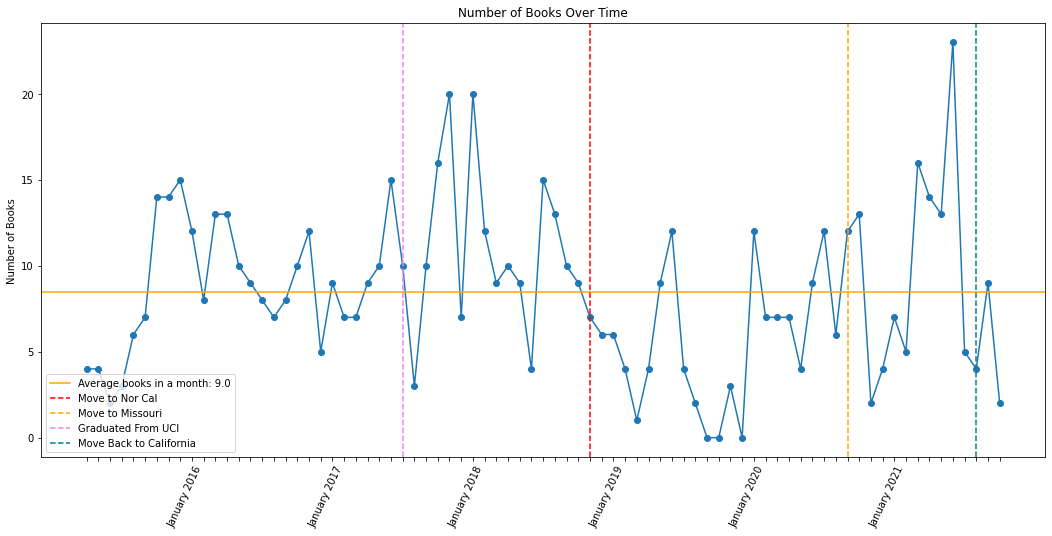

In [27]:
# plt.figure(figsize=(18, 8))
# ax = plt.subplot(122)
books_over_time(books,  show=True)

In [28]:
def pages_read_over_time(df, ax=None, show=False, pdf=None):
    pages_over_time = format_grouped_by_date(books, "pages", "mean")
    timeline = pages_over_time["timeline"]
    x_vals = [label if label.startswith("January") else "" for label in timeline]
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18,8))
    ax.plot(timeline, pages_over_time["pages"], marker="o")
    plt.axis([-3, len(x_vals)+3, 0, 700])
    plt.xticks(range(len(x_vals)), x_vals, rotation=65, ha="right")
    plt.title("Average Pages Over Time")
    plt.xlabel("")
    plt.ylabel("Average Number of Pages")
    plt.axhline(
        np.mean(pages_over_time["pages"]), 
        label="Average pages in a month: " + str(np.ceil(np.mean(pages_over_time["pages"]))), 
        color="orange"
    )

    plt.axvline("October 2018", label="Move to Northern California", color="red", linestyle="--")
    plt.axvline("August 2020", label="Move to Missouri", color="orange", linestyle="--")
    plt.axvline("June 2017", label="Graduated from UCI", color="violet", linestyle="--")
    plt.axvline("July 2021", label="Move Back to California", color="teal", linestyle="--")
    plt.legend(loc=3)
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

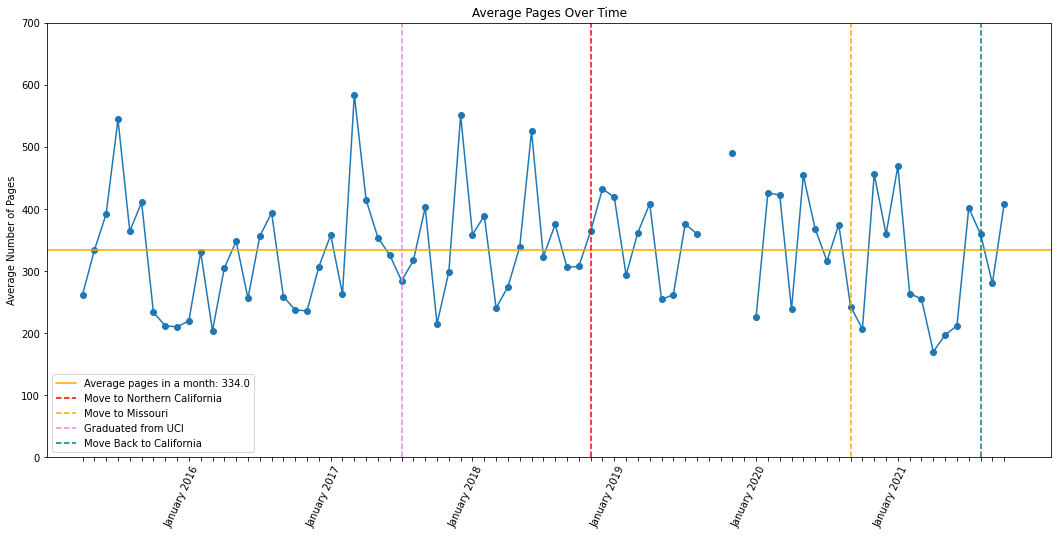

In [29]:
# ax = plt.subplot(111)
pages_read_over_time(books, show=True)

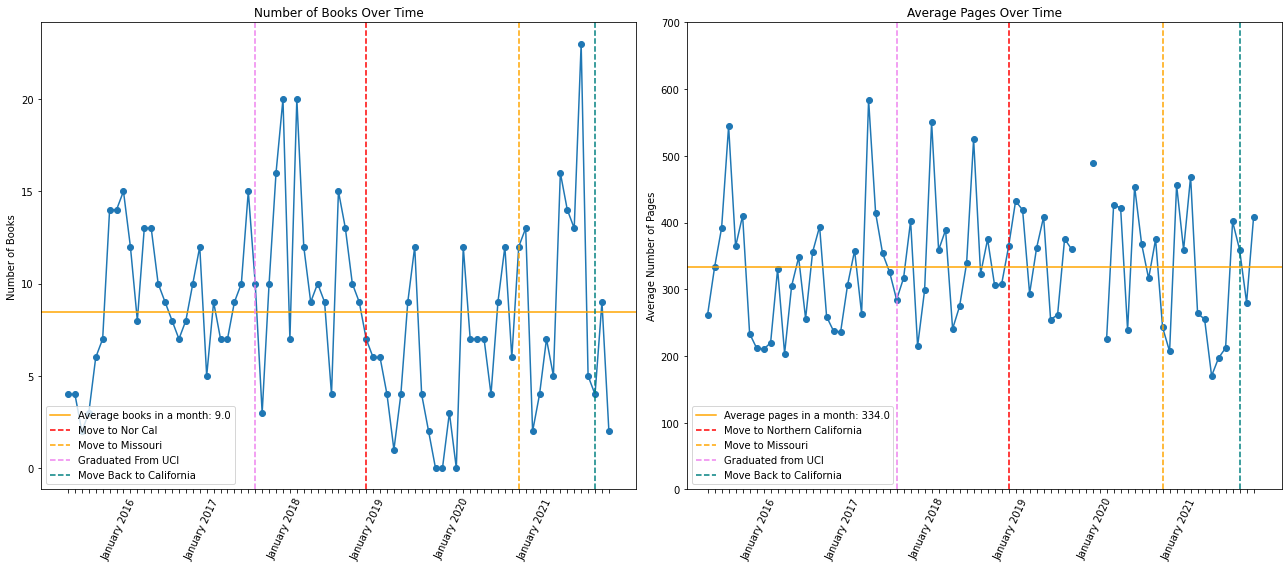

In [30]:
plt.figure(figsize=(18, 8))
ax1 = plt.subplot(121)
books_over_time(books, ax1)

ax2 = plt.subplot(122)
pages_read_over_time(books, ax2)
plt.tight_layout()
plt.show()

In [31]:
def book_length_hist(df, ax=None, show=False, pdf=None):
    page_counts = df["pages"].dropna().copy()
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(18,8))
    ax.hist(page_counts, bins=30, alpha=0.7)
    
    plt.title("Book Lengths")
    plt.ylabel("Number of Books")
    plt.xlabel("Number of Pages")
    
    mean_pages = np.mean(page_counts)
    median_pages = np.median(page_counts)
    std_pages = np.std(page_counts)
    
    plt.axvline(mean_pages, color="orange", label=f"Average Number of Pages - {np.ceil(mean_pages)}")
    plt.axvline(median_pages, color="green", label=f"Median Page Count - {np.ceil(median_pages)}")
    plt.axvline(mean_pages + std_pages, linestyle="--", color="red", label=f"1 STD Away From Mean - {np.round(std_pages, 2)}")
    plt.axvline(mean_pages - std_pages, linestyle="--", color="red")
    plt.legend()
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

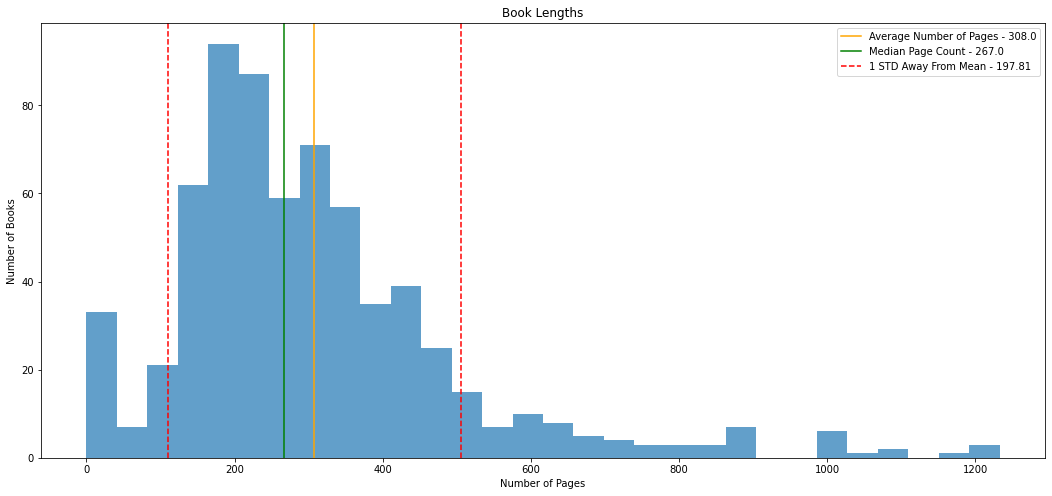

In [32]:
# plt.figure(figsize=(18, 8))
# ax = plt.subplot(121)
book_length_hist(books, show=True)

In [33]:
def make_seasons_table(df):
    spring = ["March", "April", "May"]
    summer = ["June", "July", "August"]
    fall = ["September", "October", "November"]
    winter = ["December", "January", "February"]

    book_seasons = df.copy()

    book_seasons.loc[book_seasons["finished"].dt.month_name().isin(spring), "season"] = "spring"
    book_seasons.loc[book_seasons["finished"].dt.month_name().isin(summer), "season"] = "summer"
    book_seasons.loc[book_seasons["finished"].dt.month_name().isin(fall), "season"] = "fall"
    book_seasons.loc[book_seasons["finished"].dt.month_name().isin(winter), "season"] = "winter"
    
    return book_seasons

In [34]:
def books_by_season(df, ax=None, show=False, pdf=None):
    book_seasons = make_seasons_table(df)[["title", "season"]]
    counts_by_season = book_seasons.groupby("season")["title"].count().reset_index()
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18,8))
    ax.bar(range(4), counts_by_season["title"])
    ax.set_xticks(range(4))
    ax.set_xticklabels(counts_by_season["season"])
    ax.set_title("Books By Season")
    ax.set_xlabel("")
    ax.set_ylabel("Number of Books")
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
    if show:
        plt.show()

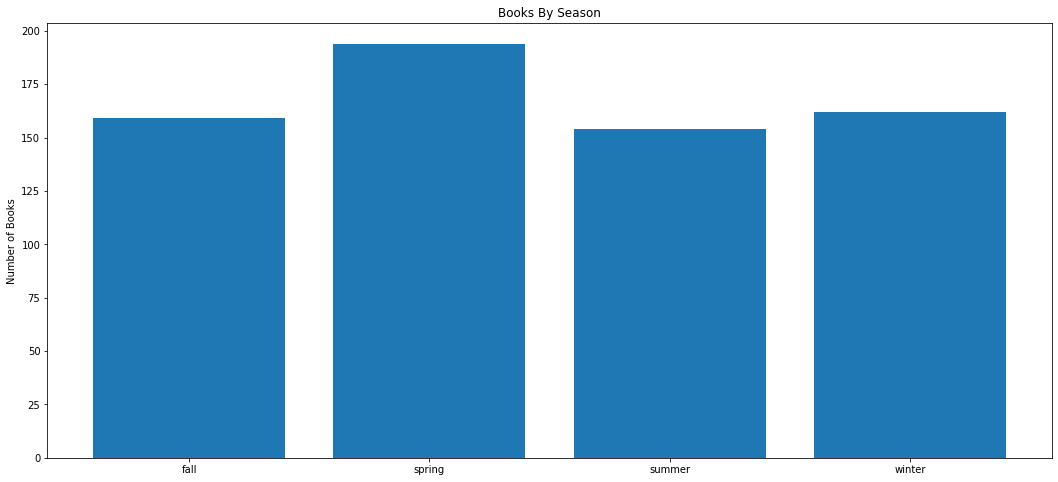

In [35]:
# plt.figure(figsize=(18,8))
books_by_season(books, show=True)

In [36]:
def pages_by_season(df, ax=None, show=False, pdf=None):
    book_seasons = make_seasons_table(books)[["pages", "season"]]
    pages_by_season = book_seasons.groupby("season")["pages"].mean().reset_index()
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18,8))
    ax.bar(range(4), pages_by_season["pages"])
    ax.set_xticks(range(4))
    ax.set_xticklabels(pages_by_season["season"], rotation=0)
    ax.set_title("Pages by Season")
    ax.set_xlabel("")
    ax.set_ylabel("Average Number of Pages")
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

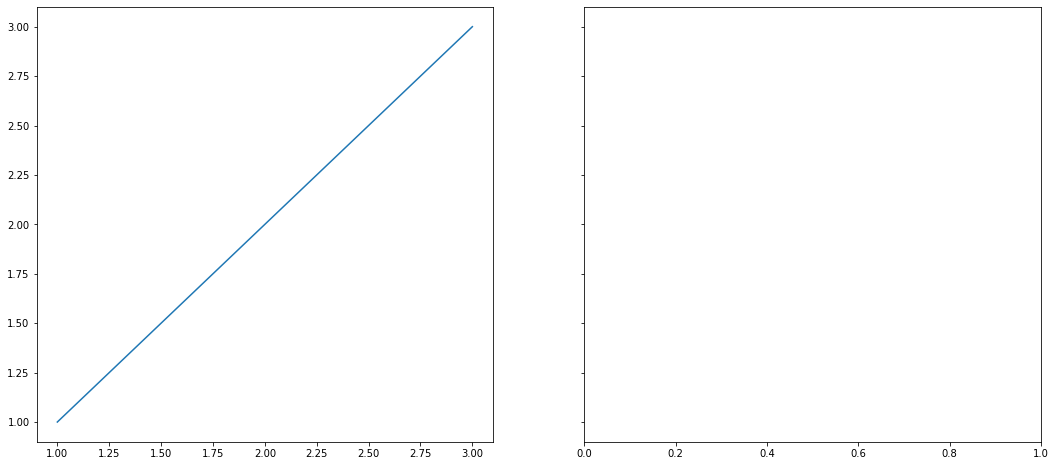

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(18,8), sharey=True)
ax[0].plot([1,2,3], [1,2,3])

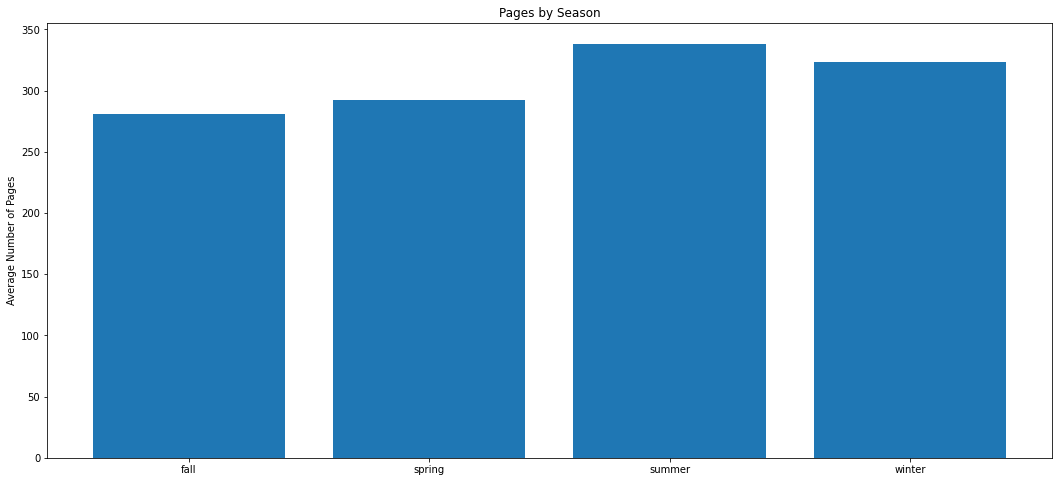

In [38]:
# plt.figure(figsize=(18, 8))
pages_by_season(books, show=True)

plt.close("all")

spring = ["March", "April", "May"]
summer = ["June", "July", "August"]
fall = ["September", "October", "November"]
winter = ["December", "January", "February"]

book_seasons = books[["title", "finished", "pages"]].copy()

book_seasons.loc[book_seasons["finished"].dt.month_name().isin(spring), "season"] = "spring"
book_seasons.loc[book_seasons["finished"].dt.month_name().isin(summer), "season"] = "summer"
book_seasons.loc[book_seasons["finished"].dt.month_name().isin(fall), "season"] = "fall"
book_seasons.loc[book_seasons["finished"].dt.month_name().isin(winter), "season"] = "winter"

counts_by_season = book_seasons.groupby("season")["title"].count().reset_index()
pages_by_season = book_seasons.groupby("season")["pages"].mean().reset_index()

ax2 = plt.subplot(1, 2, 2)
plt.bar(range(4), pages_by_season["pages"])
ax2.set_xticks(range(4))
ax2.set_xticklabels(pages_by_season["season"])
plt.title("Pages by Season")
plt.xlabel("Season")
plt.ylabel("Average Number of Pages")

plt.tight_layout()
# pdf_test.savefig()
plt.show()

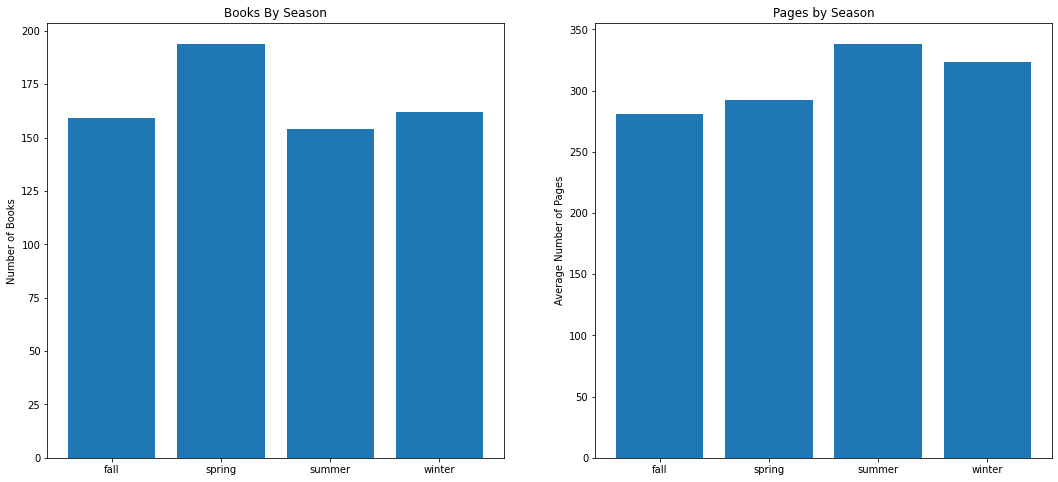

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(18,8))
books_by_season(books, ax=ax[0])
pages_by_season(books, ax=ax[1])
plt.show()

plt.clf()
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
sns.boxplot(data=book_seasons, x="season", y="pages")
plt.subplot(1, 2, 2)
sns.barplot(data=counts_by_season, x="season", y="title")
plt.tight_layout()
plt.show()

In [40]:
def add_percent_f_nf(df):
    f_nf = (
        df
        .copy()
        .groupby("f_nf")["title"]
        .count()
        .reset_index()
    )
    f_nf["pcts"] = f_nf["title"] / f_nf["title"].sum()
    return f_nf
    

In [41]:
test = add_percent_f_nf(books)

In [42]:
def fiction_vs_nonfiction(df, ax=None, show=False, pdf=None):
    f_nf = add_percent_f_nf(df)
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18,8))
    ax.pie(f_nf["pcts"], autopct="%0.1f%%", pctdistance=1.15, startangle=270, explode=[0.05,0])
    ax.pie(f_nf["pcts"], radius=0.8, colors=["white", "white"], explode=[0.05, 0], startangle=270, wedgeprops={"edgecolor": "white"})
    ax.axis("equal")
    ax.legend(f_nf["f_nf"])
    ax.set_title("Fiction / Nonfiction Proportions")
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

In [43]:
test

,f_nf,title,pcts
0,f,402,0.600897
1,nf,267,0.399103


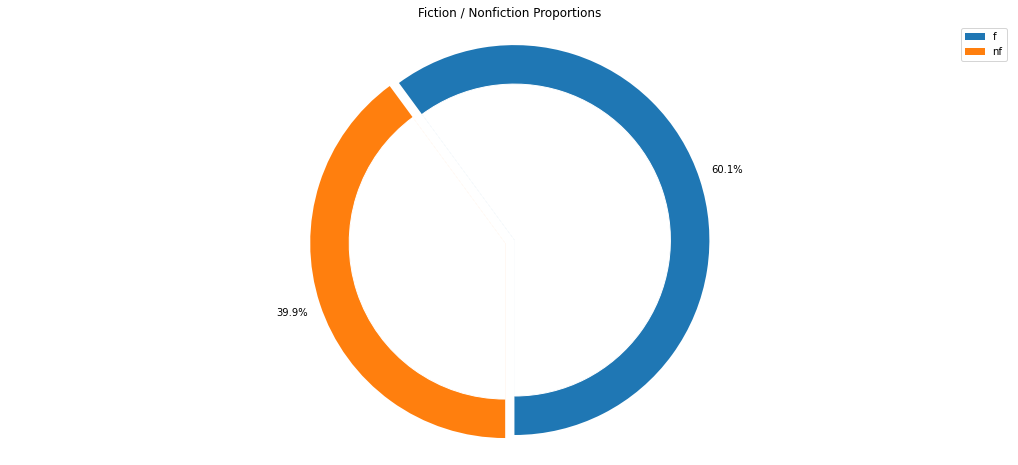

In [44]:
fiction_vs_nonfiction(books, show=True)

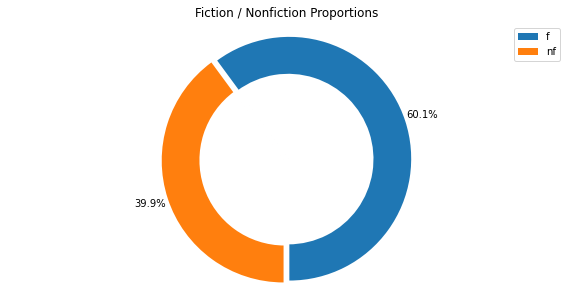

In [45]:
plt.close("all")

f_nf = books[["title", "f_nf"]].copy()
f_nf = f_nf.groupby("f_nf")["title"].count().reset_index()
f_nf["pcts"] = f_nf["title"].div(f_nf["title"].sum())

plt.figure(figsize=(10, 5))
ax = plt.subplot()
plt.pie(f_nf["pcts"], autopct="%0.1f%%", pctdistance=1.15, startangle=270, explode=[0.05, 0])
plt.pie(f_nf["pcts"], radius=0.7, colors=["white", "white"], explode=[0.04, -0.01], startangle=270)
plt.axis("equal")
plt.legend(f_nf["f_nf"])

plt.title("Fiction / Nonfiction Proportions")
# pdf_test.savefig()
plt.show()

In [46]:
def add_pct_of_rating(df):
    ratings = (
        df[["title", "rating"]]
        .copy()
        .dropna()
        .groupby("rating")["title"]
        .count()
        .reset_index()
    )
    ratings["pct_of_total"] = ratings["title"] / ratings["title"].sum()
    return ratings

In [47]:
def rating_spread(df, ax=None, show=False, pdf=None):
    ratings = add_pct_of_rating(df)
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18,8))
    percents = ratings["pct_of_total"]
    explode = [0, 0, 0, 0, 0.1, 0.1]
    ax.pie(percents, autopct="%0.1f%%", pctdistance=1.10, explode=explode)
    ax.pie(percents, colors=["white"]*len(percents), radius=0.7, center=(0,0), explode=explode, wedgeprops={"edgecolor": "white"})
    ax.legend(ratings["rating"])
    ax.set_title("Proportion of Ratings") # Using these instead of plt.title so that it stays with the axis in custom configs
    ax.axis("equal")
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

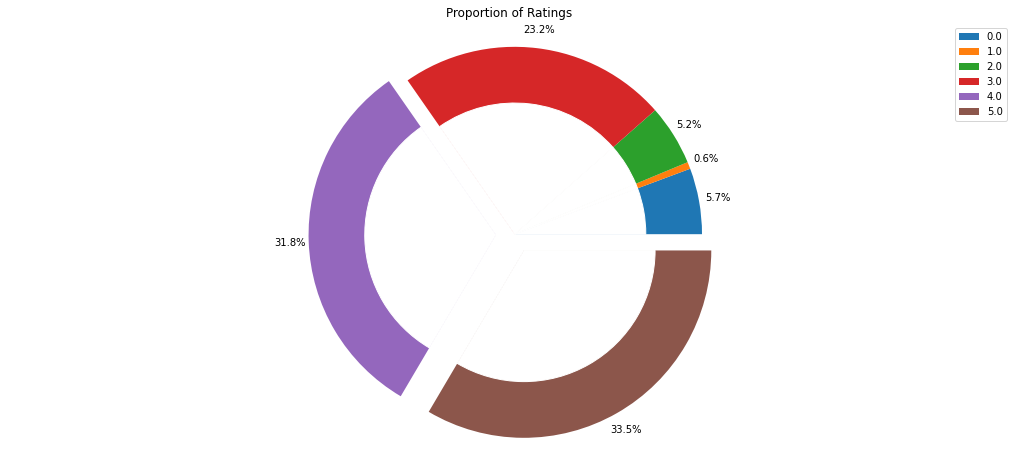

In [48]:
rating_spread(books, show=True)

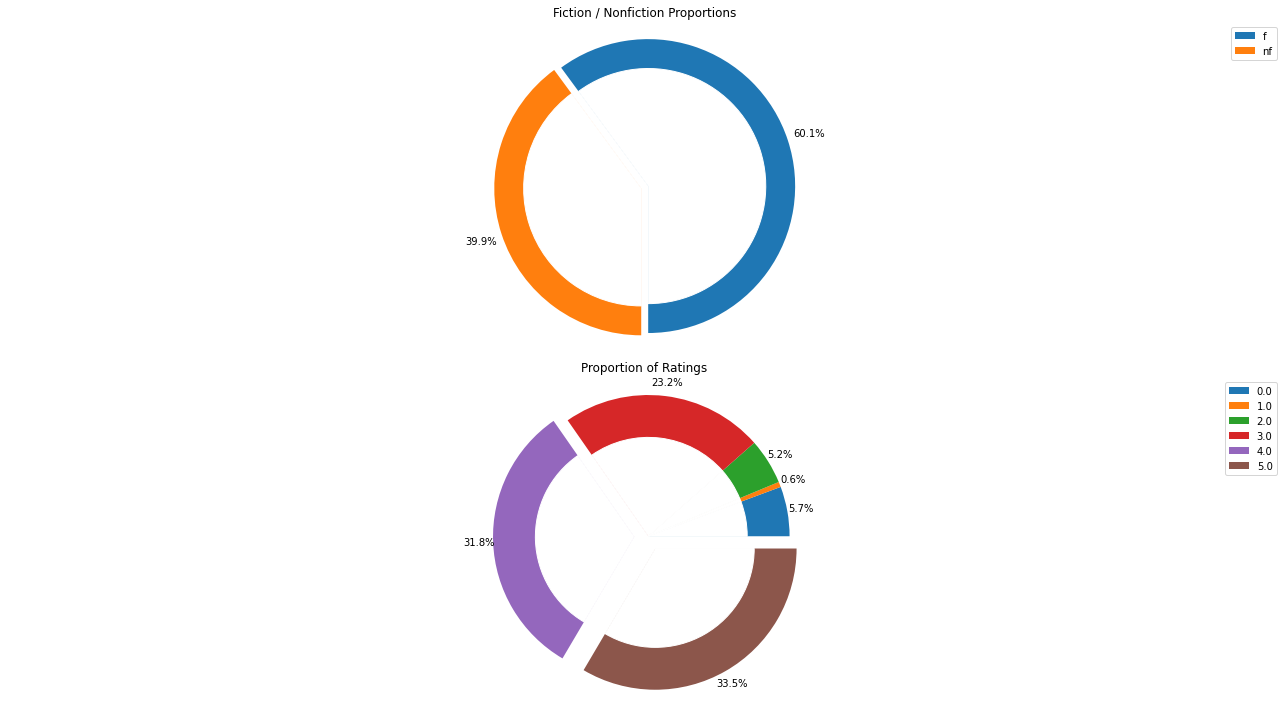

In [49]:
fig, axs = plt.subplots(2, 1, figsize=(18,10))
fiction_vs_nonfiction(books, ax=axs[0])
rating_spread(books, ax=axs[1])
plt.tight_layout()
plt.show()

In [50]:
def group_by_genre(df):
    return (
        df
        .copy()
        .dropna(subset=["genre"])
        .groupby("genre")["title"]
        .count()
        .reset_index()
        .sort_values(
            by="title",
            ascending=False
        )
    )

In [51]:
def books_by_genre(df, ax=None, show=False, pdf=None):
    books_by_genre = group_by_genre(df)
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18, 8))
    x_vals = range(len(books_by_genre["genre"]))
    ax.bar(x_vals, books_by_genre["title"])
    ax.set_xticks(x_vals)
    ax.set_xticklabels(books_by_genre["genre"],rotation=75, ha="right")
    ax.set_title("Books by Genre")
    ax.set_xlabel("")
    ax.set_ylabel("Number of Books")
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

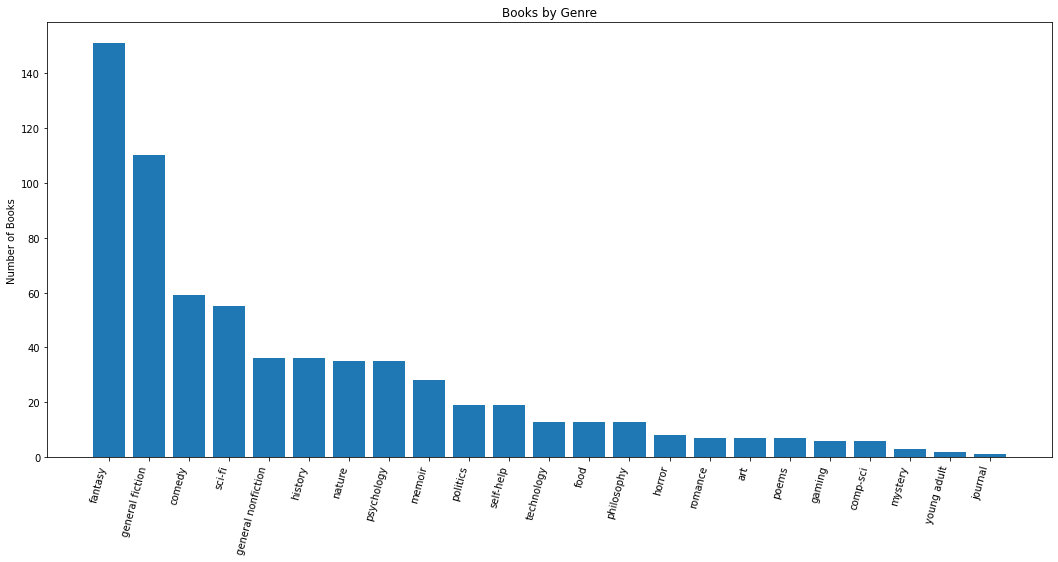

In [52]:
books_by_genre(books, show=True)

In [53]:
def group_by_source(df):
    return (
        df
        .copy()
        .dropna(subset=["source"])
        .groupby("source")["title"]
        .count()
        .reset_index()
        .sort_values(
            by="title",
            ascending=False
        )
    )

In [54]:
def books_by_source(df, ax=None, show=False, pdf=None):
    books_by_source = group_by_source(df)
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18, 8))
    x_vals = range(len(books_by_source["source"]))
    ax.bar(x_vals, books_by_source["title"])
    ax.set_xticks(x_vals)
    ax.set_xticklabels(books_by_source["source"],rotation=75, ha="right")
    ax.set_title("Books by Source")
    ax.set_xlabel("")
    ax.set_ylabel("Number of Books")
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

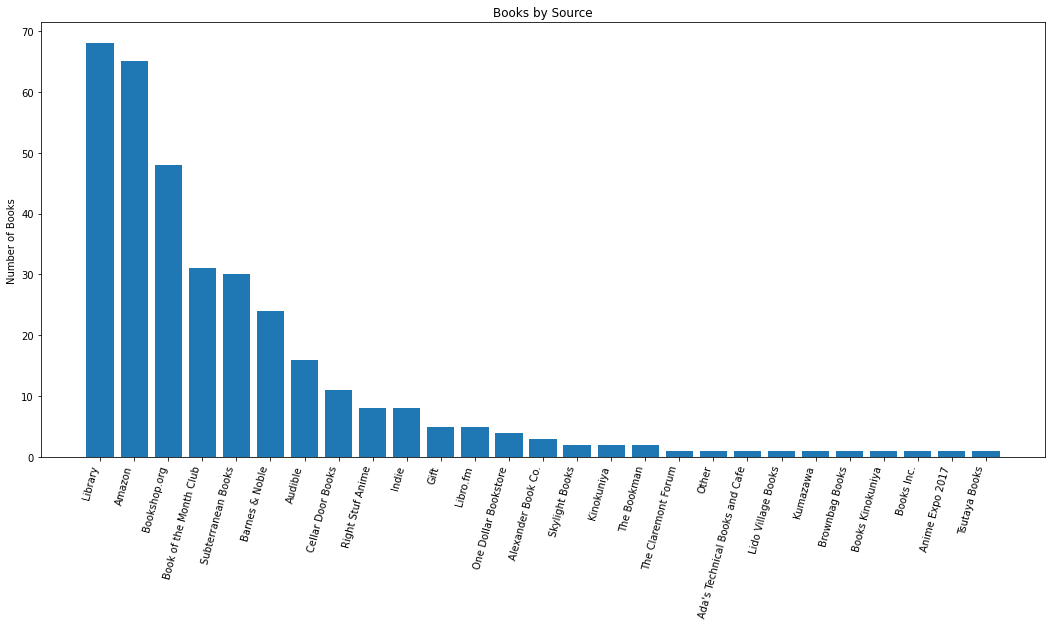

In [55]:
books_by_source(books)

plt.close("all")

books_by_genre = books[~(books["finished"].isna())][["title", "genre"]].copy().dropna()
books_by_genre = books_by_genre.groupby("genre")["title"].count().reset_index().sort_values(by="title", ascending=False)

plt.figure(figsize=(10, 6))
ax = plt.subplot()

plt.bar(range(len(books_by_genre["genre"])), books_by_genre["title"])

ax.set_xticks(range(len(books_by_genre["genre"])))
ax.set_xticklabels(books_by_genre["genre"], rotation=75)

plt.title("Books by Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Books")
plt.show()

plt.close("all")

ratings = books[["title", "rating"]].copy().dropna()

ratings = ratings.groupby("rating")["title"].count().reset_index()
# ratings["pct_of_total"] = ratings["title"].apply(lambda x: x / ratings["title"].sum())
ratings["pct_of_total"] = ratings["title"].div(ratings["title"].sum())
plt.figure(figsize=(10, 5))
plt.axis("equal")
plt.pie(ratings["pct_of_total"], autopct="%0.1f%%", pctdistance=1.15, explode=[0, 0, 0, 0, 0.1, 0.1])
plt.pie(ratings["pct_of_total"], explode=[x-0.01 for x in [0, 0, 0, 0, 0.1, 0.1]], radius=0.7, colors=["white"]*len(ratings["pct_of_total"]))
plt.legend(ratings["rating"])
plt.title("Proportion of Ratings")
# pdf_test.savefig()
plt.show()

In [56]:
books[books["title"].str.contains("City (", case=False, regex=False)]

,book_id,title,genre,pages,duration,format,year,started,finished,rating,source,imprint,days_to_finish,f_nf,year_read,month_read
599,586,City (Volume 1),comedy,162.0,0.0,gn,2017,2021-03-24,2021-03-25,5.0,Bookshop.org,Vertical Comics,1.0,f,2021,March
600,587,City (Volume 4),comedy,160.0,0.0,gn,2018,2021-03-27,2021-03-28,5.0,Bookshop.org,Vertical Comics,1.0,f,2021,March
601,588,City (Volume 7),comedy,160.0,0.0,gn,2019,2021-03-29,2021-03-30,5.0,Bookshop.org,Vertical Comics,1.0,f,2021,March
602,589,City (Volume 8),comedy,162.0,0.0,gn,2019,2021-03-30,2021-03-30,5.0,Bookshop.org,Vertical Comics,0.0,f,2021,March
603,590,City (Volume 9),comedy,162.0,0.0,gn,2019,2021-03-31,2021-03-31,5.0,Bookshop.org,Vertical Comics,0.0,f,2021,March
604,591,City (Volume 10),comedy,162.0,0.0,gn,2020,2021-03-31,2021-04-02,5.0,Bookshop.org,Vertical Comics,2.0,f,2021,April
606,592,City (Volume 2),comedy,162.0,0.0,gn,2017,2021-03-25,2021-03-26,5.0,Bookshop.org,Vertical Comics,1.0,f,2021,March
607,593,City (Volume 3),comedy,162.0,0.0,gn,2017,2021-03-26,2021-03-27,5.0,Bookshop.org,Vertical Comics,1.0,f,2021,March
608,594,City (Volume 5),comedy,160.0,0.0,gn,2018,2021-03-28,2021-03-28,5.0,Bookshop.org,Vertical Comics,0.0,f,2021,March
609,595,City (Volume 6),comedy,160.0,0.0,gn,2018,2021-03-29,2021-03-29,4.0,Bookshop.org,Vertical Comics,0.0,f,2021,March


In [57]:
def get_books_read_in_pub_year(df, year):
    return df[
        (df["finished"].dt.year == year)
        & (df["year"] == year)
    ].copy()

def get_y_vals_by_year(df, year_list):
    return [
        len(get_books_read_in_pub_year(df, year)) / len(df[df["finished"].dt.year == year])
        for year in year_list
    ]

def get_totals(df, year_list):
    return [
        len(df[df["finished"].dt.year == year])
        for year in year_list
    ]

In [58]:
x_values = ["2016", "2017", "2018", "2019", "2020"]
list(map(int, x_values))

[2016, 2017, 2018, 2019, 2020]

In [59]:
def top_bars(ax, y_vals):
    ax.bar(range(6), [1-y_val for y_val in y_vals], bottom=y_vals, label="Backlog")

In [60]:
def current_releases(df, ax=None, show=False, pdf=None):
    x_vals = ["2016", "2017", "2018", "2019", "2020", "2021"]
    year_list = list(map(int, x_vals))
    y_vals = get_y_vals_by_year(df, year_list)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(18, 8))
    
    ax.bar(range(6), y_vals, label="Read in Year Pubbed")
    
    for idx, value in enumerate(y_vals):
        ax.text(
            idx, 
            value+0.025, 
            str(round(value, 2)*100) + "%",
            horizontalalignment="center", 
            fontweight="bold", 
            fontsize=14
        )
    totals = get_totals(df, year_list)
    for idx, value in enumerate(totals):
        ax.text(idx, 0.8, "Total\nBooks:\n"+ str(value), horizontalalignment="center", fontweight="bold")
    top_bars(ax, y_vals)
    ax.set_xticks(range(6))
    ax.set_xticklabels(x_vals)
    ax.set_title("Books Read in Year of Publication")
    ax.set_ylabel("Proportion of Books")
    ax.set_xlabel("")
    ax.legend()
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

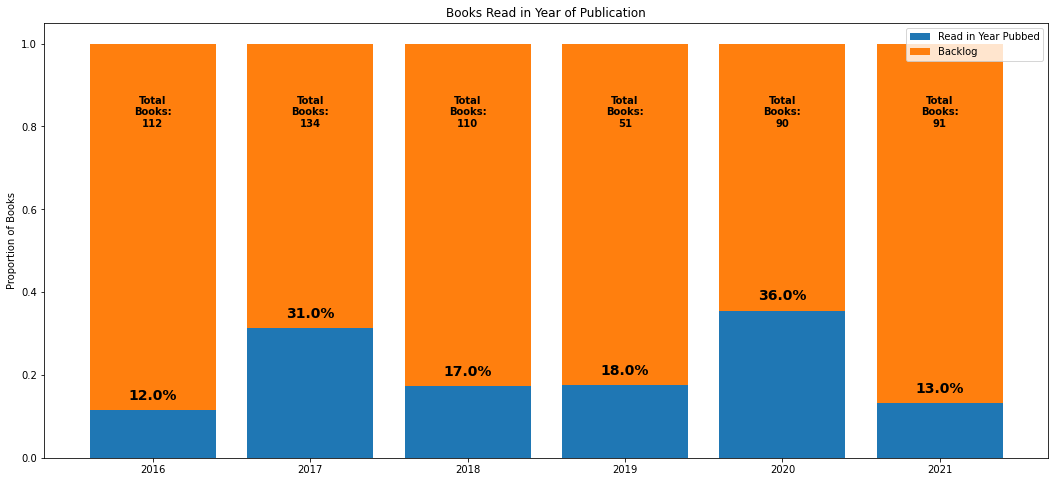

In [61]:
current_releases(books, show=True)

In [62]:
def books_by_year(df, ax=None, show=False, pdf=None):
    x_values = ["2016", "2017", "2018", "2019", "2020", "2021"]
    year_list = list(map(int, x_values))
    totals = get_totals(df, year_list)
    mean_totals = np.mean(totals)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(18, 8))
    ax.bar(range(6), totals)
    ax.set_xticks(range(6))
    ax.set_xticklabels(x_values)
    plt.axhline(mean_totals, label=f"Avg Per Year - {mean_totals}")
    ax.set_title("Totals Per Year")
    ax.set_ylabel("Number of Books")
    ax.set_xlabel("")
    ax.legend()
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

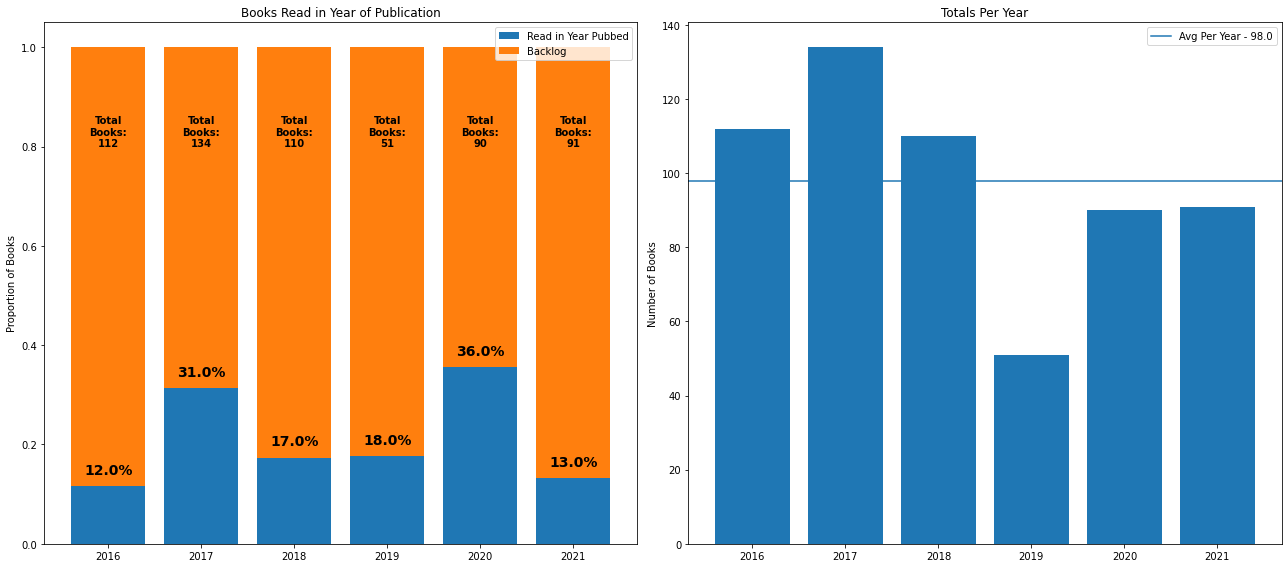

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))
current_releases(books, ax=axs[0])
books_by_year(books, ax=axs[1])
plt.tight_layout()
plt.show()

In [64]:
def group_by_format(df):
    return (
        df[~df["finished"].isna()]
        .copy()
        .groupby("format")["title"]
        .count()
        .reset_index()
        .sort_values(by="title", ascending=False)
    )

In [65]:
def books_by_format(df, ax=None, show=False, pdf=None):
    books_by_format = group_by_format(df)
    x_vals = books_by_format["format"]
    y_vals = books_by_format["title"]
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(18, 8))
    ax.bar(range(len(x_vals)), y_vals)
    ax.set_xticks(range(len(x_vals)))
    ax.set_xticklabels(x_vals)
    ax.set_title("Book by Format")
    plt.xlabel("")
    plt.ylabel("Number of Books")
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

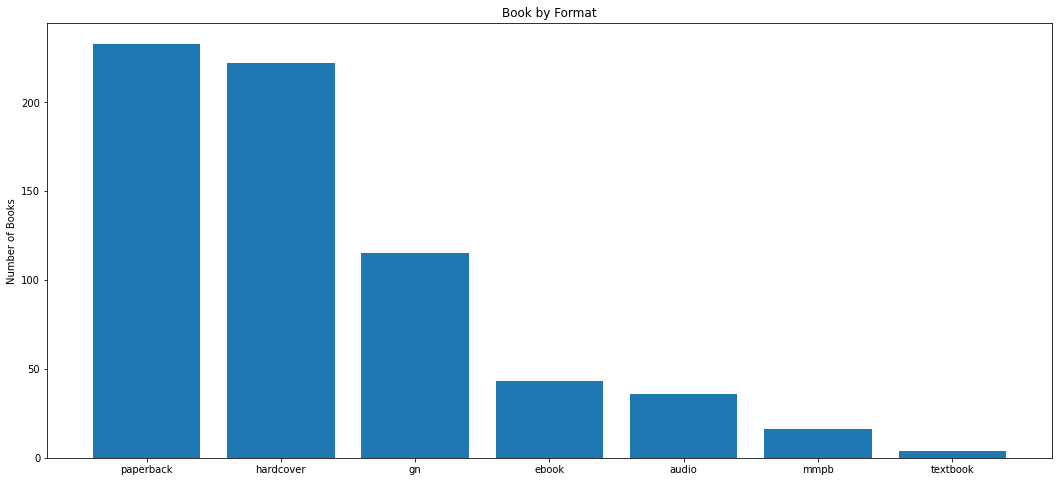

In [66]:
books_by_format(books, show=True)

In [67]:
def reading_speed_kde(df):
    squared_df = df.copy()
    plt.close("all")
    plt.figure(figsize=(12, 8))
    sns.kdeplot(data=squared_df, x="days_to_finish", shade=True)
    mean_days = np.mean(df["days_to_finish"])
    median_days = np.median(df[["days_to_finish"]].dropna()["days_to_finish"])
    mode_days, mode_counts = stats.mode(df[["days_to_finish"]].dropna()["days_to_finish"])
    std_days = np.std(df["days_to_finish"])
    plt.axvline(mean_days, label=f"Mean Days to Finish a Book - {np.round(mean_days, 1)}", color="red", linestyle="--")
    plt.axvline(median_days, label=f"Median Days to Finish a Book - {median_days}", color="green", linestyle="--")
    plt.axvline(mode_days, label=f"Mode Days to Finish a Book - {mode_days[0]}", color="violet", linestyle="--")
    plt.axvline(mean_days + std_days, label="1 std away", color="orange", linestyle="--")
    plt.xlim([0, int(df["days_to_finish"].max())+10])
    plt.legend()
#     pdf_test.savefig()
    plt.show()

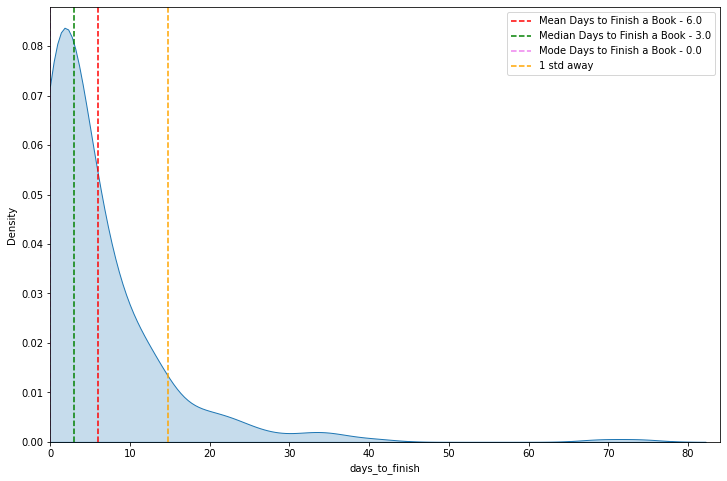

In [68]:
reading_speed_kde(books)

plt.close("all")
plt.figure(figsize=(18, 200))
ax = plt.subplot()
ax.axis("off")
ax.axis("tight")
ax.table(cellText=books.values, colLabels=books.columns, bbox=[0,0,1,1])
pdf_test.savefig()

In [69]:
# pdf_test.close()

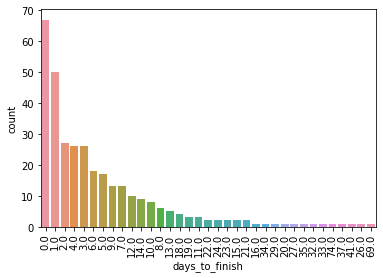

In [70]:
plt.close("all")
sns.countplot(x=books["days_to_finish"], order=books["days_to_finish"].value_counts().index)
plt.xticks(rotation=90)
plt.show()

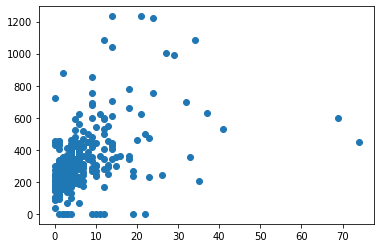

In [71]:
plt.close("all")
plt.scatter(x=books["days_to_finish"], y=books["pages"])
plt.show()

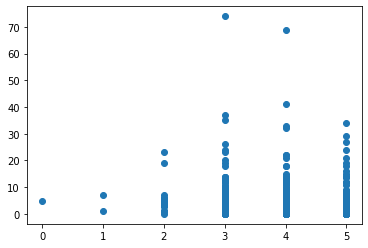

In [72]:
plt.close("all")
plt.scatter(x=books["rating"], y=books["days_to_finish"])
plt.show()

In [73]:
books.describe()

,book_id,pages,duration,year,rating,days_to_finish,year_read
count,669.000000,668.000000,633.000000,669.000000,669.000000,328.000000,669.000000
mean,325.638266,307.609281,23.715640,1997.403587,3.753363,6.009146,2017.855007
std,198.078549,197.955385,116.802717,117.418675,1.296186,8.725332,1.944952
min,1.000000,0.000000,0.000000,180.000000,0.000000,0.000000,2015.000000
25%,149.000000,187.000000,0.000000,2006.000000,3.000000,1.000000,2016.000000
50%,335.000000,266.500000,0.000000,2014.000000,4.000000,3.000000,2018.000000
75%,496.000000,384.000000,0.000000,2017.000000,5.000000,8.000000,2020.000000
max,691.000000,1233.000000,1115.000000,2021.000000,5.000000,74.000000,2021.000000


# Challenge: Find Associations Between Different Categorical Variables

In [74]:
books.head()

,book_id,title,genre,pages,duration,format,year,started,finished,rating,source,imprint,days_to_finish,f_nf,year_read,month_read
0,1,Uzumaki,horror,656.0,0.0,gn,2000,NaT,2017-05-17,4.0,Right Stuf Anime,Viz Media,NaN,f,2017,May
1,2,The Shallows: What the Internet Is Doing to Ou...,technology,280.0,0.0,paperback,2010,NaT,2017-10-01,4.0,Amazon,Norton,NaN,nf,2017,October
2,3,The Sixth Extinction: An Unnatural History,nature,336.0,0.0,hardcover,2014,NaT,2015-03-06,4.0,None,Henry Holt,NaN,nf,2015,March
3,4,The Name of the Wind (The Kingkiller Chronicle...,fantasy,662.0,0.0,hardcover,2007,NaT,2017-02-28,4.0,Amazon,DAW,NaN,f,2017,February
4,5,"The Wise Man's Fear (The Kingkiller Chronicle,...",fantasy,994.0,0.0,hardcover,2011,NaT,2017-03-13,5.0,Amazon,DAW,NaN,f,2017,March


In [75]:
pd.crosstab(books["f_nf"], books["year"])

year,180,650,1593,1608,1729,1832,1848,1849,1861,1866,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
f_nf,,,,,,,,,,,,,,,,,,,,,
f,0,1,1,1,0,1,0,0,1,1,...,15,12,27,14,24,52,23,27,33,8
nf,2,0,0,0,1,0,1,1,0,0,...,11,12,19,15,19,41,19,12,17,4


In [76]:
books["genre"].value_counts()

fantasy               151
general fiction       110
comedy                 59
sci-fi                 55
history                36
general nonfiction     36
nature                 35
psychology             35
memoir                 28
politics               19
self-help              19
technology             13
food                   13
philosophy             13
horror                  8
romance                 7
art                     7
poems                   7
comp-sci                6
gaming                  6
mystery                 3
young adult             2
journal                 1
Name: genre, dtype: int64

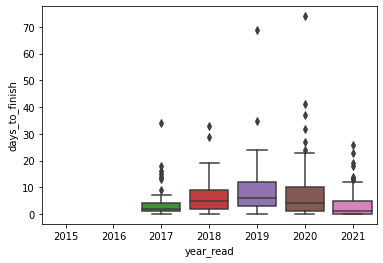

In [77]:
def reading_speed(df):
    sns.boxplot(data=df, x="year_read", y="days_to_finish")
    plt.show()
reading_speed(books)


ax = plt.subplot(111)

sub_df = books[["title", "author", "finished"]]
ax.axis("off")
ax.axis("tight")

ax.table(cellText=sub_df.values, colLabels=sub_df.columns, loc="center")
plt.show()

In [78]:
books

,book_id,title,genre,pages,duration,format,year,started,finished,rating,source,imprint,days_to_finish,f_nf,year_read,month_read
0,1,Uzumaki,horror,656.0,0.0,gn,2000,NaT,2017-05-17,4.0,Right Stuf Anime,Viz Media,NaN,f,2017,May
1,2,The Shallows: What the Internet Is Doing to Ou...,technology,280.0,0.0,paperback,2010,NaT,2017-10-01,4.0,Amazon,Norton,NaN,nf,2017,October
2,3,The Sixth Extinction: An Unnatural History,nature,336.0,0.0,hardcover,2014,NaT,2015-03-06,4.0,None,Henry Holt,NaN,nf,2015,March
3,4,The Name of the Wind (The Kingkiller Chronicle...,fantasy,662.0,0.0,hardcover,2007,NaT,2017-02-28,4.0,Amazon,DAW,NaN,f,2017,February
4,5,"The Wise Man's Fear (The Kingkiller Chronicle,...",fantasy,994.0,0.0,hardcover,2011,NaT,2017-03-13,5.0,Amazon,DAW,NaN,f,2017,March
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,673,Rent-A-Girlfriend (Volume 7),romance,208.0,NaN,gn,2018,2021-08-28,2021-08-28,4.0,Bookshop.org,Kodansha Comics,0.0,f,2021,August
696,674,City (Volume 12),comedy,162.0,NaN,gn,2020,2021-08-28,2021-08-28,4.0,Bookshop.org,Vertical Comics,0.0,f,2021,August
697,294,Ricky Gervais Presents: The World of Karl Pilk...,general nonfiction,240.0,0.0,paperback,2006,2021-08-20,2021-08-30,3.0,None,Hachette,10.0,nf,2021,August
698,670,Damnation Spring,general fiction,442.0,NaN,hardcover,2021,2021-09-02,2021-09-12,3.0,Book of the Month Club,Scribner,10.0,f,2021,September


In [79]:
def show_rereads(df):
    read_counts = df["title"].value_counts()
    masked = df.copy()
    masked["title"] = masked.mask(masked["title"].isin(read_counts[read_counts == 1].index), "NA")
    masked = masked[masked["title"] != "NA"]
    sns.countplot(x=masked["title"], order=masked["title"].value_counts().index)
    plt.xticks(rotation=90)
    plt.show()
    

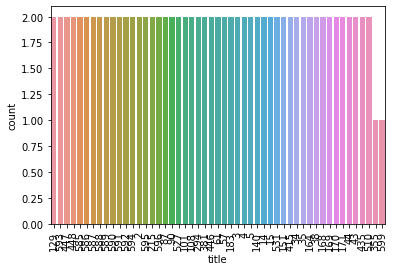

In [80]:
show_rereads(books)

In [81]:
books.tail()

,book_id,title,genre,pages,duration,format,year,started,finished,rating,source,imprint,days_to_finish,f_nf,year_read,month_read
695,673,Rent-A-Girlfriend (Volume 7),romance,208.0,NaN,gn,2018,2021-08-28,2021-08-28,4.0,Bookshop.org,Kodansha Comics,0.0,f,2021,August
696,674,City (Volume 12),comedy,162.0,NaN,gn,2020,2021-08-28,2021-08-28,4.0,Bookshop.org,Vertical Comics,0.0,f,2021,August
697,294,Ricky Gervais Presents: The World of Karl Pilk...,general nonfiction,240.0,0.0,paperback,2006,2021-08-20,2021-08-30,3.0,None,Hachette,10.0,nf,2021,August
698,670,Damnation Spring,general fiction,442.0,NaN,hardcover,2021,2021-09-02,2021-09-12,3.0,Book of the Month Club,Scribner,10.0,f,2021,September
699,691,Coders,general nonfiction,375.0,NaN,hardcover,2019,2021-09-12,2021-09-18,3.0,Library,Penguin Press,6.0,nf,2021,September


In [82]:
books[books["year_read"] == 2021]

,book_id,title,genre,pages,duration,format,year,started,finished,rating,source,imprint,days_to_finish,f_nf,year_read,month_read
571,568,The Tower of Fools (Hussite Trilogy #1),fantasy,549.0,0.0,paperback,2020,2020-12-29,2021-01-11,3.0,Subterranean Books,Orbit,13.0,f,2021,January
575,572,The Practice,self-help,0.0,338.0,audio,2020,2021-01-03,2021-01-05,3.0,Libro.fm,Penguin Audio,2.0,nf,2021,January
576,573,How I Learned to Understand the World,general nonfiction,0.0,514.0,audio,2020,2021-01-06,2021-01-25,3.0,Libro.fm,Macmillan Audio,19.0,nf,2021,January
578,576,The Signal and the Noise,nature,454.0,0.0,paperback,2015,2021-01-23,2021-02-05,4.0,Barnes & Noble,Penguin,13.0,nf,2021,February
579,577,Sid Meier's Memoir!,memoir,273.0,0.0,hardcover,2020,2021-01-20,2021-01-23,4.0,Barnes & Noble,W.W. Norton,3.0,nf,2021,January
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,673,Rent-A-Girlfriend (Volume 7),romance,208.0,NaN,gn,2018,2021-08-28,2021-08-28,4.0,Bookshop.org,Kodansha Comics,0.0,f,2021,August
696,674,City (Volume 12),comedy,162.0,NaN,gn,2020,2021-08-28,2021-08-28,4.0,Bookshop.org,Vertical Comics,0.0,f,2021,August
697,294,Ricky Gervais Presents: The World of Karl Pilk...,general nonfiction,240.0,0.0,paperback,2006,2021-08-20,2021-08-30,3.0,None,Hachette,10.0,nf,2021,August
698,670,Damnation Spring,general fiction,442.0,NaN,hardcover,2021,2021-09-02,2021-09-12,3.0,Book of the Month Club,Scribner,10.0,f,2021,September
